# Experiments with Facebook Prophet
Sample dataset from daily recording of time taken to run, from one of my scripts that run daily.

Few things that are illustrated are:
1. Sampling on date index to fill missing dates in pandas data frame
1. Predicting the values for next month
1. Anomaly detection when the data goes beyond some boundaries
1. Panda's html style formatting with anomaly to color code
1. Time series dataframe split into weekly tables display and with color coding by anomalies. Great to quickly see weekly trends.

In [1]:
import pandas as pd
from fbprophet import Prophet
import altair as alt
import datetime

In [2]:
def parser(x):
    """Custom parser for our date column"""
    return pd.datetime.strptime(x, '%y%m%d')

df = pd.read_csv('prophet_example_weekly.csv', sep="|", parse_dates=[0],  squeeze=True, date_parser=parser)
df.columns = ['ds', 'y'] #Prophet needs columns to be named as ds and y for datestamp and value respectively
df.tail(10)

,ds,y
103,2019-11-02,955
104,2019-11-03,816
105,2019-11-04,1741
106,2019-11-05,1457
107,2019-11-06,1218
108,2019-11-07,1933
109,2019-11-08,1450
110,2019-11-09,1418
111,2019-11-10,1170
112,2019-11-11,1020


If there is data missing for some dates, let us fill it by zeros

In [3]:
df = df.set_index("ds")
df = df.resample("D").asfreq().fillna(0)

That filled it up. Now, Prophet library doesn't need an index - so get rid of that and check the data again.

In [4]:
df.reset_index(inplace=True)
df.columns = ["ds", "y"]

In [5]:
m = Prophet(daily_seasonality=False, yearly_seasonality=False)
m.fit(df)

# let us extend future for 30 days and predict.
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

/home/vsbabu/apps/anaconda3/envs/cenv/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



,ds,yhat,yhat_lower,yhat_upper
138,2019-12-07,1211.065416,784.348968,1587.795847
139,2019-12-08,911.843652,519.109135,1290.835558
140,2019-12-09,1379.547259,981.501263,1773.971619
141,2019-12-10,1291.542796,906.471255,1682.579439
142,2019-12-11,1373.996240,1001.473355,1762.942231


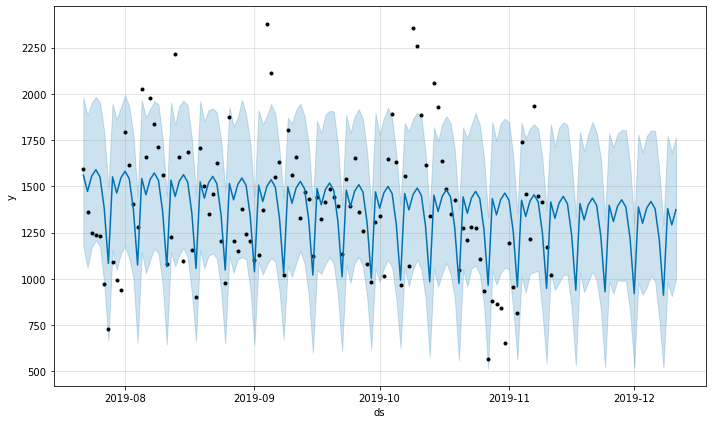

In [6]:
fig1 = m.plot(forecast)

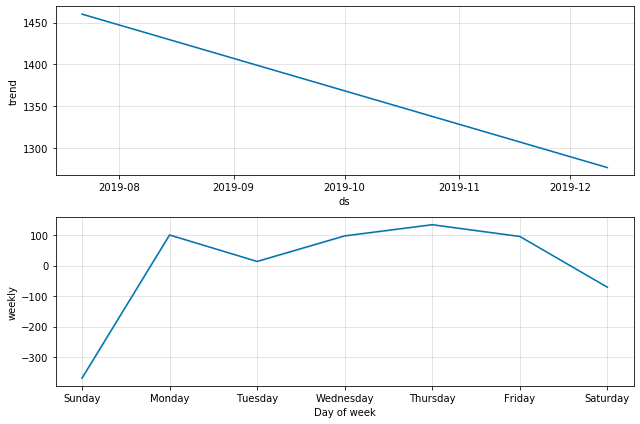

In [7]:
fig2 = m.plot_components(forecast)

## Anomaly Detection
Most of the code here is from the article at https://medium.com/seismic-data-science/anomaly-detection-using-prophet-a5dcea2c5473

In [8]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    """
    Play with interval width and changepoint rainge to see how much you want to keep as a range for
    anomaly detection. Seasonality of data should also be considered.
    """
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = True,
                seasonality_mode = 'multiplicative',   #some data are additive; some are multiplicative
                interval_width = interval_width,
                changepoint_range = changepoint_range)
   # m.add_country_holidays(country_name='IN') #note that this is not enough to remove weekends
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    #and have the actual value available readily
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast
    
pred = fit_predict_model(df, 0.6, 0.4)

In [9]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()

    forecasted['anomaly'] = 0
    #if value is above upper bound, anomaly is +1; if below lower bound, -1.
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances as a %age above or below boundaries
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

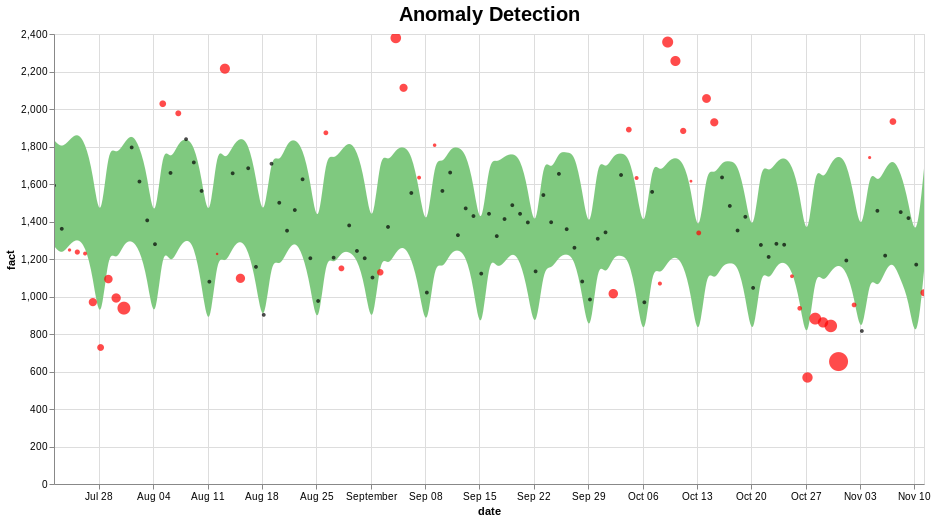

In [10]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='fact'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='fact'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
              
plot_anomalies(pred)

In [11]:
#let us just filter out points that have anomalies
pred.loc[pred['anomaly']!=0].head(10)

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
2,2019-07-24,1458.774888,1559.004854,1278.628743,1835.784526,1248,-1,0.024542
3,2019-07-25,1457.490052,1593.829809,1311.250491,1875.131259,1237,-1,0.060025
4,2019-07-26,1456.205217,1554.807666,1272.299167,1822.285125,1229,-1,0.035231
5,2019-07-27,1454.920381,1381.393719,1115.242057,1664.735340,970,-1,0.149734
6,2019-07-28,1453.635545,1074.886595,804.444828,1344.669615,728,-1,0.105007
7,2019-07-29,1452.350709,1554.733174,1268.720621,1821.500068,1093,-1,0.160769
8,2019-07-30,1451.065873,1466.491704,1182.088204,1751.836374,992,-1,0.191621
9,2019-07-31,1449.781037,1549.393051,1285.593040,1816.819479,938,-1,0.370568
14,2019-08-05,1443.356858,1545.105308,1289.176287,1823.421616,2028,1,0.100877
16,2019-08-07,1440.787185,1539.781247,1256.695145,1821.816266,1977,1,0.078495


## Highlight Anomaly
Let us color positive anomaly with green and negative with orange.

We will need to only consider `date`, `fact` and `anomaly` fields. `anomaly` is +1 or -1 depending upon if it is positive or negative.

Just to be safer, we will copy the predicted dataframe to another dataframe, `edf` with only these columns. For brevity, we will copy only last 10 rows in df.

In [12]:
def highlight_anomaly(d):
    p_anom = 'background-color: lightgreen'
    n_anom = 'background-color: darkorange'
    regular = ''
    p_mask = d['anomaly'] > 0
    n_mask = d['anomaly'] < 0
    df1 = pd.DataFrame(regular, index=d.index, columns=d.columns)
    df1.loc[p_mask, 'fact'] = p_anom
    df1.loc[n_mask, 'fact'] = n_anom
    return df1


edf = pred[['ds','fact','anomaly']].copy().tail(10)
edf.set_index('ds', inplace=True)
edf.style. \
    apply(highlight_anomaly, axis=None).hide_columns(['anomaly'])   

,fact
ds,
2019-11-02 00:00:00,955
2019-11-03 00:00:00,816
2019-11-04 00:00:00,1741
2019-11-05 00:00:00,1457
2019-11-06 00:00:00,1218
2019-11-07 00:00:00,1933
2019-11-08 00:00:00,1450
2019-11-09 00:00:00,1418
2019-11-10 00:00:00,1170


## Weekly matrix for last 8 weeks
I find the weekly data table for last 8 weeks including the current week to be of tremendous value in visualization.

In [13]:
how_many_weeks = 8
start_week_date = (datetime.date.today() + datetime.timedelta(6 + (datetime.date.today().weekday() + 1) % 7)) - datetime.timedelta(how_many_weeks*7)
dates = pd.date_range(start_week_date, periods=how_many_weeks * 7)
edf = pred[['ds','fact','anomaly']].copy()
edf.set_index('ds', inplace=True)
edf=edf.reindex(dates).fillna(0)
wkv = edf[['fact', 'anomaly']].copy().values.reshape(how_many_weeks,7*2)
# We got a weekly df now

In [14]:
# let us make columns properly
efw = edf[edf.index.weekday_name == "Monday"]
efw = pd.DataFrame(
    wkv, index=efw.index, columns=["mon", "a_mon", "tue", "a_tue", "wed", "a_wed", "thu", "a_thu", "fri", "a_fri", "sat", "a_sat", "sun", "a_sun"]
)
efw.index.name = "week"
efw.sort_index(ascending=False, inplace=True)



In [15]:
def highlight_anomaly_wk(d):
    p_anom = 'background-color: lightgreen'
    n_anom = 'background-color: darkorange'
    regular = ''
    df1 = pd.DataFrame(regular, index=d.index, columns=d.columns)
    for wd in "mon tue wed thu fri sat sun".split():
        a = 'a_'+wd
        p_mask = d[a] > 0
        n_mask = d[a] < 0
        df1.loc[p_mask, wd] = p_anom
        df1.loc[n_mask, wd] = n_anom
    return df1

efw.style. \
    apply(highlight_anomaly_wk, axis=None). \
    hide_columns(["a_mon", "a_tue", "a_wed", "a_thu", "a_fri", "a_sat", "a_sun"])
   

,mon,tue,wed,thu,fri,sat,sun
week,,,,,,,
2019-11-11 00:00:00,1020,0,0,0,0,0,0
2019-11-04 00:00:00,1741,1457,1218,1933,1450,1418,1170
2019-10-28 00:00:00,882,862,843,653,1192,955,816
2019-10-21 00:00:00,1275,1211,1281,1276,1108,937,568
2019-10-14 00:00:00,2056,1929,1635,1483,1352,1425,1046
2019-10-07 00:00:00,1558,1069,2357,2256,1883,1615,1339
2019-09-30 00:00:00,1308,1342,1015,1648,1890,1632,969
2019-09-23 00:00:00,1541,1396,1654,1359,1260,1080,984
